In [2]:
#!/usr/bin/python3
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

%matplotlib inline

In [3]:
def timescanplot(fname, location, save, show, depletion=False):
    os.chdir(location)
    with open(fname, 'r') as f: file = f.readlines()
    
    skip = [num for num, line in enumerate(file) if 'ALL:' in line.split()]
    iterations = np.array([int(i.split()[-1].strip()) for i in file if '#mass' in i.split()])
    length = len(iterations)

    data = np.genfromtxt(fname, skip_header = skip[0]+1)

    cycle = int(len(data)/iterations.sum())
    time = data[:,1][:cycle]

    temp, temp1, temp2, mass, counts = [], [], [], [], []
    k = 0
    for i in range(len(iterations)):
        j = iterations[i]*cycle
        mass.append(data[:,0][k])
        counts.append(data[:,2][k:k+j])
        k += j
        
        for c in range(cycle):
            for l in range(iterations[i]):
                temp.append(counts[i][(l*cycle)+c])
            temp1.append(temp)
            temp = []
        temp2.append(temp1)
        temp1 = []
        
    mean = [[np.array(temp2[i][j]).mean() for j in range(cycle)]for i in range(length)]
    error = [[(np.array(temp2[i][j]).std()/np.sqrt(iterations[i])) for j in range(cycle)]for i in range(length)]
    mass, mean, error = np.array(mass), np.array(mean), np.array(error)

    if depletion: return mass, iterations, mean, error, time

    plt.figure(figsize=(15,5), dpi=100)

    for i in range(length):
        lg = "%i:%i"%(mass[i], iterations[i])
        plt.errorbar(time, mean[i],error[i],fmt='.-', label = lg)
        
    plt.title('Time Scan plot for %s'%fname)
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()

    if save: plt.savefig(fname.split('.')[0]+'.png')
    if show: plt.show()
    
    plt.close()

In [4]:
def func(t, A, k):
    return A*(1-np.exp(-k*t))

In [5]:
location = r'D:\FELion-Spectrum-Analyser\testing\_datas'
save = False
show = True

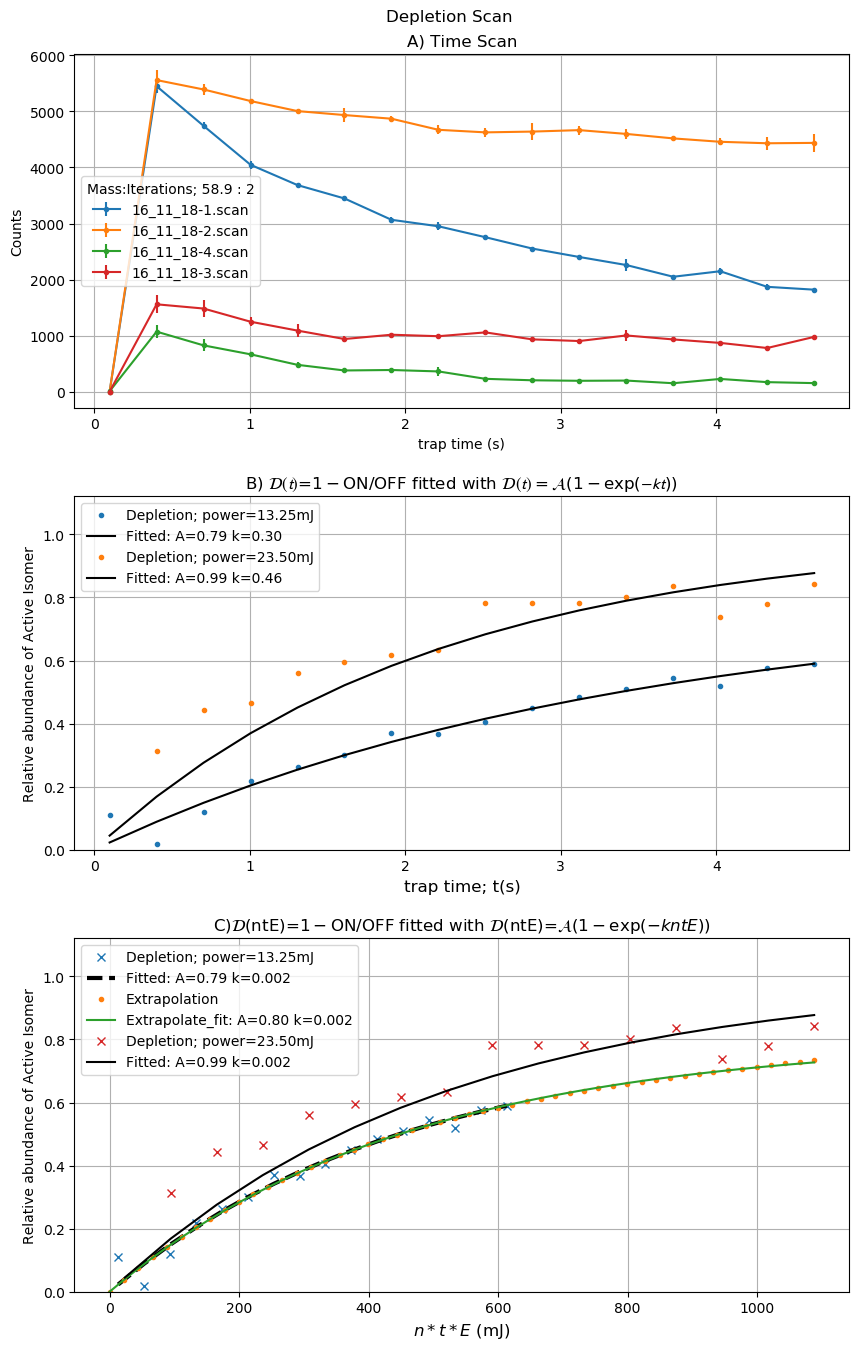

In [6]:
def depletionPlot(files, location, save, show, power_values):
    
    os.chdir(location)
    
    power_values_temp = np.array(power_values)
    power_values = np.array([np.array([a, b]).mean() for a, b in zip(power_values[::2], power_values[1::2])])
    power_error = np.array([np.array([a, b]).std() for a, b in zip(power_values_temp[::2], power_values_temp[1::2])])
    
    plt.rcParams['figure.figsize'] = (10,15)
    plt.rcParams['figure.dpi'] = 100
    
    fig, axs = plt.subplots(3)
 
    graph = {}
    for i, ax in enumerate(axs.flat):
        graph['%i'%i] = ax    

    plt.subplots_adjust(top=0.95, hspace=0.25)
    plt.suptitle('Depletion Scan' ,fontsize=12)
    full = []
    
    for f in files:
        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time/1000
        x, y = time, mean[0]
        
        graph['0'].errorbar(x, y,yerr=error[0], fmt='.-', label=f)

        full.append(y)    
    
    time = np.array(time)
    
    interp_range = time.max()*power_values.max()*10
    interp_range = round(interp_range, 1)
    power_new = np.linspace(0, interp_range)
    
    for i, pw in zip(range(0, len(full), 2), power_values):
        
        depletion = (full[i+1]-full[i])/full[i+1]
        
        #depletion as a function of time
        pop, popc = curve_fit(func, time, depletion)
        y_fit = func(time, *pop)

        graph['1'].plot(time, depletion,'.', label = 'Depletion; power=%.2fmJ'%pw)
        graph['1'].plot(time, y_fit, 'k', label = 'Fitted: A=%.2f k=%.2f'%tuple(pop))
        
        #depletion as a function of power
        power = np.array(time*10*pw)
        
        pop1, popc1 = curve_fit(func, power, depletion,  p0=[0.01, 0.004])
        power_fit = func(power, *pop1)
        
        power_max = round(power.max(), 1)
        
        if power_max >= interp_range:
            graph['2'].plot(power, depletion,'x', label = 'Depletion; power=%.2fmJ'%pw)
            graph['2'].plot(power, power_fit,'k',label = 'Fitted: A=%.2f k=%.3f'%tuple(pop1))
        
        if power_max < interp_range:
            graph['2'].plot(power, depletion,'x', label = 'Depletion; power=%.2fmJ'%pw)
            graph['2'].plot(power, power_fit,'--k',lw=3,label = 'Fitted: A=%.2f k=%.3f'%tuple(pop1))
            
            interp_f = interp1d(power, power_fit, kind='cubic', bounds_error=False, fill_value='extrapolate')
            graph['2'].plot(power_new, interp_f(power_new),'.', label = 'Extrapolation')
            
            pop2, popc2 = curve_fit(func, power_new, interp_f(power_new),  p0=[0.01, 0.004])
            interp_fit = func(power_new, *pop2)
            
            graph['2'].plot(power_new, interp_fit,label = 'Extrapolate_fit: A=%.2f k=%.3f'%tuple(pop2))
    
    graph['0'].set_ylabel('Counts')
    graph['0'].legend(title='Mass:Iterations; %s : %s'%(mass[0], iterations[0]))
    graph['0'].set_xlabel('trap time (s)')
    graph['0'].set_title('A) Time Scan')
    
    graph['1'].set_ylim(ymin=0)
    graph['1'].set_xlabel('trap time; t(s)', fontsize=12)
    graph['1'].set_ylabel('Relative abundance of Active Isomer')
    graph['1'].legend()
    graph['1'].set_title(r'B) $\mathcal{D(t)}$=$1-$ON/OFF fitted with $\mathcal{D(t)}=\mathcal{A}(1-\exp(\mathcal{-kt}))$')
    
    graph['2'].set_ylim(ymin=0)
    graph['2'].legend()
    graph['2'].set_xlabel( '$ n * t * E $ (mJ)', fontsize=12)
    graph['2'].set_ylabel('Relative abundance of Active Isomer')
    graph['2'].set_title('C)$\mathcal{D}$(ntE)=$1-$ON/OFF fitted with $\mathcal{D}$(ntE)=$\mathcal{A}(1-\exp(-kntE))$')
    
    for ax in axs.flat:
        ax.grid(True)
    
    if save: plt.savefig('depletion.png')
    if show: plt.show()
    plt.tight_layout()
    plt.close()

files = ['16_11_18-4.scan', '16_11_18-3.scan']
files1 = ['16_11_18-1.scan', '16_11_18-2.scan', '16_11_18-4.scan', '16_11_18-3.scan']
files2 = ['16_11_18-1.scan', '16_11_18-2.scan']
depletionPlot(files1, location, save=True, show=True, power_values=[12, 14.5, 22, 25])

In [123]:
def N_ON(t, Na0, Nn0, K_OFF, K_ON): return Na0*np.exp(-K_ON*t)*np.exp(-K_OFF*t) + Nn0*np.exp(-K_OFF*t)

def N_OFF(t, Na0, Nn0, K_OFF): return (Na0+Nn0)*np.exp(-K_OFF*t)

def Depletion(t, A, K): return A*(1-np.exp(-K*t))

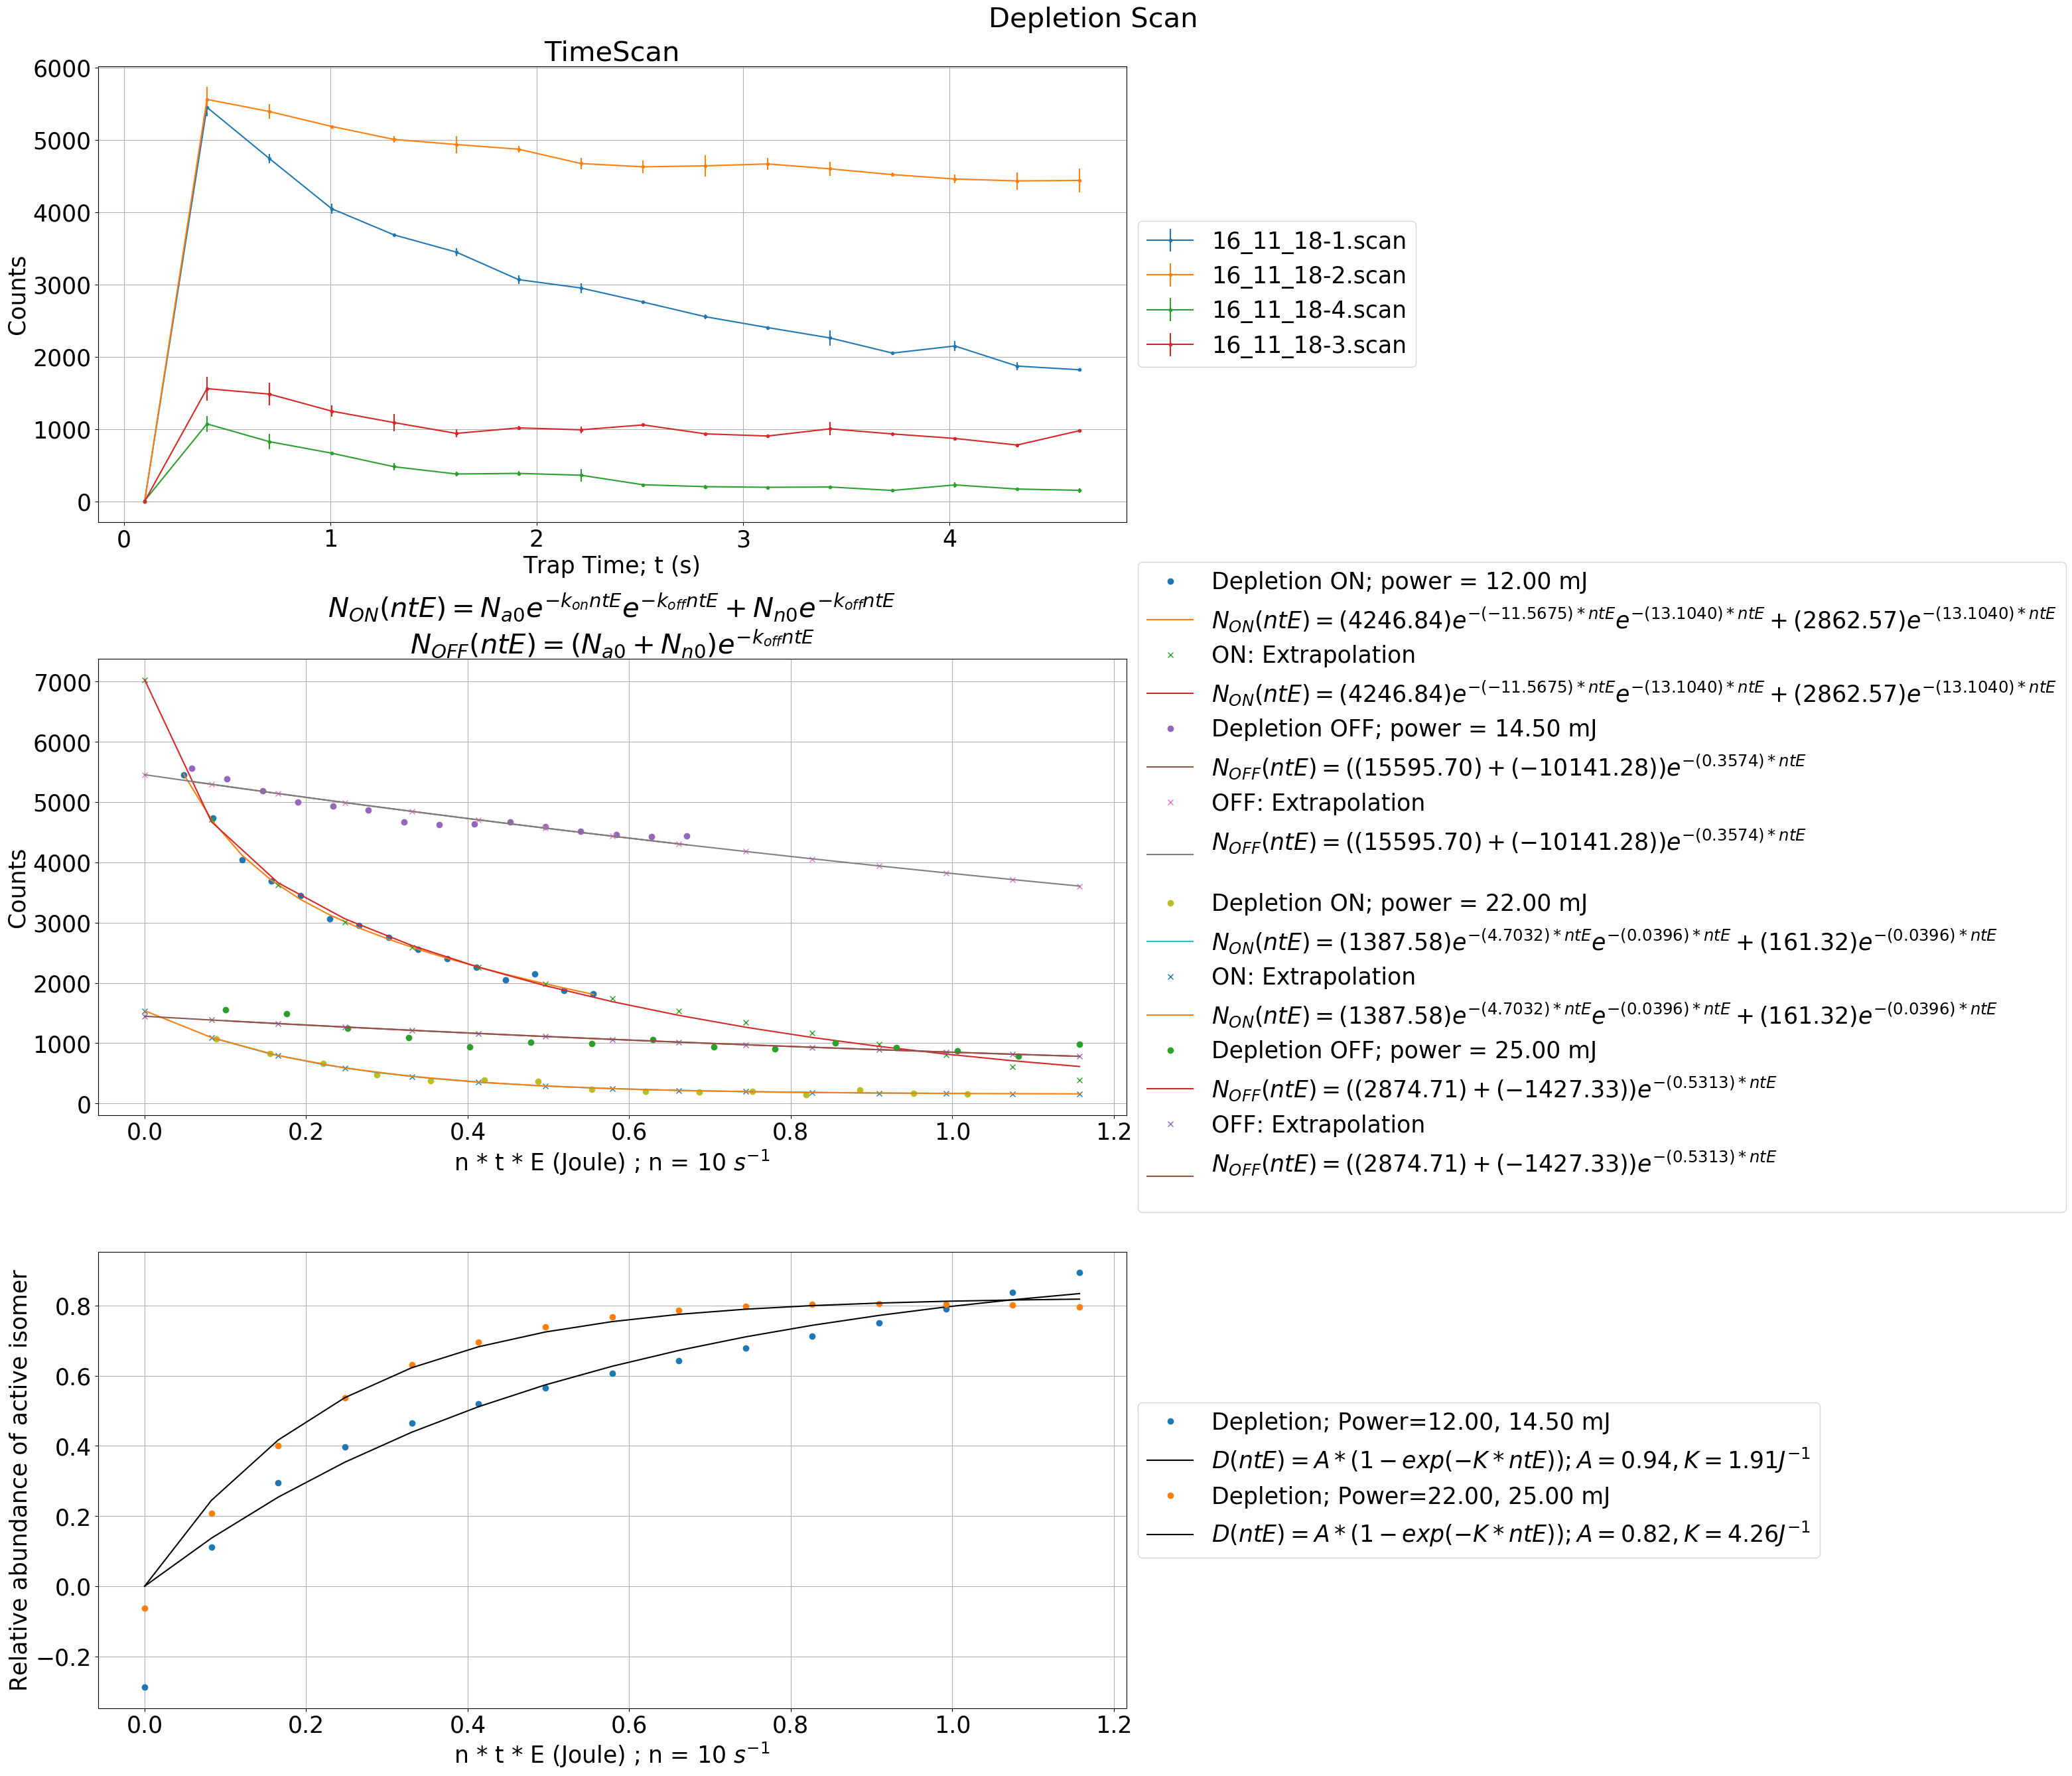

In [122]:
def depletionPlot1(files, location, save, show, power_values, n):
    
    power_values = np.array(power_values)
    
    np.seterr(all='ignore')
    
    os.chdir(location)
    
    plt.rcParams['figure.figsize'] = (40, 30)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams.update({'font.size': 25})
    
    
    fig, axs = plt.subplots(3, sharex=False)
 
    graph = {}
    for i, ax in enumerate(axs.flat):
        graph['%i'%i] = ax

    plt.subplots_adjust(top=0.95, hspace=0.3)
    plt.suptitle('Depletion Scan')
    
    full = []
    
    for f in files:
        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time/1000
        
        x, y = time, mean[0]
        graph['0'].errorbar(x, y,yerr=error[0], fmt='.-', label=f)

        full.append(y)
        
    time = np.array(time)
    
    for i in range(0, len(full), 2):
        
        depletion = 1-(full[i]/full[i+1])

        new_time = time[1:]
        new_depletion = depletion[1:]
        
        depletion_ON = full[i][1:]
        depletion_OFF = full[i+1][1:]
        
        power_ON = (power_values[i]*n*new_time)/1000.
        power_OFF = (power_values[i+1]*n*new_time)/1000.
        
        power_max = power_values.max()*n*time.max()/1000.
        
        length = len(new_depletion)
        power_new = np.linspace(0, power_max, num=length)
        
        #Fitting initial parameter
        p0 = [0,0,0,0]
        
        ############## Depletion ON ##############
        x, d = power_ON, depletion_ON
        graph['1'].plot(x, d,'o', label = 'Depletion ON; power = %.2f mJ'%power_values[i])
        
        pop1, popc1 = curve_fit(N_ON, x, d, p0)
        y = N_ON(x, *pop1)
        
        graph['1'].plot(x, y,\
                        label = '$N_{ON}(ntE)=(%.2f)e^{-(%.4f)*ntE}e^{-(%.4f)*ntE} + (%.2f)e^{-(%.4f)*ntE}$'\
                       %(pop1[0], pop1[3], pop1[2], pop1[1], pop1[2]))
        
        #Extrapolating the points for range [0, power_max] which is power_new
        power_interp_func = interp1d(x, y, kind='cubic', bounds_error=False, fill_value='extrapolate')
        power_ON_extrapolated = power_interp_func(power_new)
        graph['1'].plot(power_new, power_ON_extrapolated ,'x', label = 'ON: Extrapolation')
        
        x_new, d_new = power_new, power_ON_extrapolated
        pop2, popc2 = curve_fit(N_ON, x_new, d_new, p0)
        y_new = N_ON(x_new, *pop2)
        
        graph['1'].plot(x_new, y_new,\
                        label = '$N_{ON}(ntE)=(%.2f)e^{-(%.4f)*ntE}e^{-(%.4f)*ntE} + (%.2f)e^{-(%.4f)*ntE}$'\
                       %(pop1[0], pop1[3], pop1[2], pop1[1], pop1[2]))
        
        ####################################################################################
        ####################################################################################
        
        ############## Depletion OFF ##############
        x1, d1 = power_OFF, depletion_OFF
        
        graph['1'].plot(x1, d1,'o', label = 'Depletion OFF; power = %.2f mJ'%power_values[i+1])
        
        pop3, popc3 = curve_fit(N_OFF, x1, d1)
        y1 = N_OFF(x1, *pop3)
        
        graph['1'].plot(x1, y1,label = '$N_{OFF}(ntE)=((%.2f) + (%.2f))e^{-(%.4f)*ntE}$'%tuple(pop3))
        
        #Extrapolating the points for range [0, power_max] which is power_new
        power_interp_func = interp1d(x1, y1, kind='cubic', bounds_error=False, fill_value='extrapolate')
        power_OFF_extrapolated = power_interp_func(power_new)
        graph['1'].plot(power_new, power_OFF_extrapolated ,'x', label = 'OFF: Extrapolation')
        
        d1_new = power_OFF_extrapolated
        pop4, popc4 = curve_fit(N_OFF, x_new, d1_new)
        y1_new = N_OFF(x_new, *pop3)
        
        graph['1'].plot(x_new, y1_new,label = '$N_{OFF}(ntE)=((%.2f) + (%.2f))e^{-(%.4f)*ntE}$\n'%tuple(pop3))
        
        ####################################################################################
        ####################################################################################
        
        
        ## Depletion
        power_depletion = 1-d_new/d1_new
        graph['2'].plot(x_new, power_depletion,'o', label='Depletion; Power=%.2f, %.2f mJ'%(power_values[i], power_values[i+1]))
        
        pop5, popc5 = curve_fit(Depletion, x_new, power_depletion)
        depletion_fit = Depletion(x_new, *pop5)
        
        graph['2'].plot(x_new, depletion_fit,'-k', label='$D(ntE)=A*(1-exp(-K*ntE)); A=%.2f, K=%.2f J^{-1}$'%tuple(pop5))

    # Setting graph Parameters
    graph['0'].set_title('TimeScan')
    #graph['0'].legend()
    graph['0'].set_ylabel('Counts')
    graph['0'].set_xlabel('Trap Time; t (s)')

    graph['1'].set_title('$N_{ON}(ntE)=N_{a0}e^{-k_{on}ntE}e^{-k_{off}ntE} + N_{n0}e^{-k_{off}ntE}$\n$N_{OFF}(ntE)=(N_{a0}+ N_{n0})e^{-k_{off}ntE}$')
    graph['1'].set_xlabel('n * t * E (Joule) ; n = %i $s^{-1}$'%n)
    graph['1'].set_ylabel('Counts')
    
    graph['2'].set_xlabel('n * t * E (Joule) ; n = %i $s^{-1}$'%n)
    graph['2'].set_ylabel('Relative abundance of active isomer')
    
    for ax in axs.flat:
        ax.grid(True)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if save: plt.savefig("Depletion.pdf", bbox_inches='tight')
    if show: plt.show()
    plt.tight_layout()
    plt.close()

files = ['16_11_18-4.scan', '16_11_18-3.scan']
files1 = ['16_11_18-1.scan', '16_11_18-2.scan', '16_11_18-4.scan', '16_11_18-3.scan']
files2 = ['16_11_18-1.scan', '16_11_18-2.scan']
depletionPlot1(files1, location, save=True, show=True, power_values=[12, 14.5, 22, 25], n=10)

In [121]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']
